# Convolutional Filtering

In [1]:
%run ../setup.ipynb

In the previous section, we saw that the convolution theorem lets us reason about the effects of an impulse response $\red{H}$ in terms of each sinusoidal component.
Specifically, the convolution theorem says that if $\purple{y} = \red{h}*\blue{x}$, then

```{math}
\magenta{Y[m]} = \red{H[m]} \cdot \darkblue{X[m]},
```
and we can interpret $\red{H[m]} = A \cdot e^{\mathrm{j}\cdot\phi}$ as applying a gain $A$ and delay $\phi$ to the sinusoid of frequency $\frac{m}{N} \cdot f_s$.

We'll investigate delay and phase in the next section, and focus here on the gain.
Intuitively, if the magnitude $A$ is small,

```{math}
A = |\red{H[m]}| \approx 0,
```

then $|\magenta{Y[m]}|$ must be small as well, regardless of $\darkblue{X[m]}$.
This gives us a way to attenuate or eliminate frequencies in $\darkblue{X}$ when constructing $\magenta{Y}$!

Alternately, if $A$ is large, then the corresponding frequency will be amplified.
We'll focus in this section primarily on the attenuation case, which often has more practical relevance.

## Low-pass filters

To begin, we'll create a **low-pass filter**, meaning that the filter allows low frequencies to pass through to the output, and stops high frequencies.

```{margin} Why low-pass filters?

We focus on low-pass filters here because A) they're useful, and B) they can be used to construct other filters.

If we apply a low-pass filter to $x$ resulting in $y$, then $x - y$ should contain whatever is left over: this gives us a **high-pass** filter.

If we then apply another low-pass filter (with a higher cut-off frequency than before), we'd get a **band-pass** filter.

If we subtract the result of the band-pass filter from the original signal, we'd get a **notch** filter.
```

### Moving average filters

One way to create a low-pass filter (though not a very good one) is to average sample values together over a short window of time:

```{math}
\purple{y[n]} =  \sum_{k=0}^{K-1} \red{\frac{1}{K}} \cdot \blue{x[n-k]},
```
which is known as a **moving average filter**.
We can define the impulse response of this filter as
```{math}
\red{h[n]} = \begin{cases}
\frac{1}{K} & n < K\\
0 & \text{otherwise},
\end{cases}
```
and the length $K$ is known as the *order* of the filter.

As illustrated below, high frequencies will oscillate within the time window, and average to zero (or close to it), while low frequencies will not.

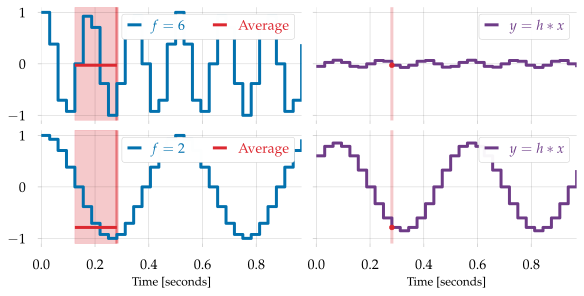

In [2]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=figaspect(0.5))

fs = 32
N = fs

f1 = 6
f2 = 2

t = np.arange(N) / fs
x1 = np.cos(2 * np.pi * f1 * t)
x2 = np.cos(2 * np.pi * f2 * t)

h = np.ones(5) / 5
#y1 = scipy.signal.convolve(x1, h, mode='same', method='fft')
#y2 = scipy.signal.convolve(x2, h, mode='same', method='fft')
y1 = np.fft.irfft(np.fft.rfft(x1) * np.fft.rfft(h, n=len(x1)))
y2 = np.fft.irfft(np.fft.rfft(x2) * np.fft.rfft(h, n=len(x2)))

offset = 4
axes[0, 0].step(t, x1, where='post', label=f'$f={f1}$')
axes[0, 0].axvspan(t[offset], t[offset+len(h)], zorder=-2, color=colors[1], alpha=0.25)
axes[0, 0].axvline(t[offset +len(h)], zorder=-1, color=colors[1], alpha=0.5)

axes[0, 0].plot([t[offset], t[offset+len(h)]], [y1[offset+len(h)], y1[offset+len(h)]], color=colors[1], label='Average')
axes[0, 0].legend(loc='upper right', ncol=2, labelcolor='linecolor', frameon=True, framealpha=0.99)
axes[0, 1].axvline(t[offset +len(h)], zorder=-1, color=colors[1], alpha=0.25)

axes[0, 1].step(t, y1, color=colors[4], where='post', label='$y= h*x$')
axes[0, 1].legend(loc='upper right', ncol=2, labelcolor='linecolor', frameon=True)
axes[0, 1].scatter(t[offset + len(h)], y1[offset + len(h)], color=colors[1], marker='o', zorder=10)

axes[1, 0].step(t, x2, where='post', label=f'$f={f2}$')
axes[1, 0].axvspan(t[offset], t[offset+len(h)], zorder=-2, color=colors[1], alpha=0.25)
axes[1, 0].axvline(t[offset +len(h)], zorder=-1, color=colors[1], alpha=0.5)
axes[1, 0].plot([t[offset], t[offset+len(h)]], [y2[offset+len(h)], y2[offset+len(h)]], color=colors[1], label='Average')
axes[1, 0].legend(loc='upper right', ncol=2, labelcolor='linecolor', frameon=True, framealpha=0.99)

axes[1, 1].step(t, y2, color=colors[4],  where='post', label='$y=h*x$')
axes[1, 1].legend(loc='upper right', ncol=2, labelcolor='linecolor', frameon=True)
axes[1, 1].scatter(t[offset + len(h)], y2[offset + len(h)], color=colors[1], marker='o', zorder=10)
axes[1, 1].axvline(t[offset +len(h)], zorder=-1, color=colors[1], alpha=0.25)

axes[1, 0].set(xlabel='Time [seconds]')
axes[1, 1].set(xlabel='Time [seconds]')
glue('moving-average', fig, display=False)

```{glue:figure} moving-average
**Left**: two waves at frequencies $f=6$ (top) and $f=2$ (bottom) are sampled at $f_s = 32$ for one second.
A moving average filter of order $K=5$ (shaded region) is applied to produce the output signals $\purple{y}=\red{h}*\blue{x}$ via circular convolution (**right** plots).
The solid horizontal lines (left) correspond to the average value over the window (marked points in the right plots).
The high frequency signal (top) is significantly attenuated, while the lower frequency signal is not.
```

The moving average can be understood as an average of delay filters:

```{math}
\red{h} = \frac{1}{K} \cdot \left( [1, 0, 0 \dots] + [0, 1, 0, 0, \dots] + \dots \right),
```
so the DFT $\red{H}$ can be interpreted as the average of the DFT of delays.
As we saw previously, the {ref}`DFT of a delay is a sinusoid <dft-impulse>`.
By DFT linearity, the DFT of the average of delays is therefore the average of the DFT of delays.
So if $h$ is an order-$K$ moving average filter, then its DFT will be

```{math}
\red{H[m]} = \red{\frac{1}{K}} \cdot \sum_{k=0}^{K-1} \blue{e^{-2\pi\cdot\mathrm{j} \cdot m \cdot k / N}}
```
as visualized below.

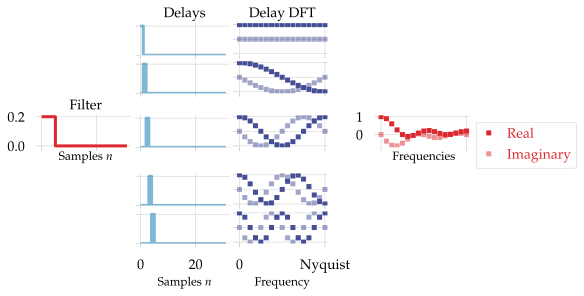

In [3]:
fig, ax = plt.subplots(nrows=5, ncols=4, sharex='col', sharey=False, figsize=figaspect(.5))

N = 32
K = 5
for n in range(K):
    x = np.zeros(N)
    x[n] = 1
    X = np.fft.rfft(x)
    ax[n, 1].step(np.arange(len(x)), x, where='post', alpha=0.5)
    ax[n, 2].plot(X.real, marker='s',  linestyle='', label='Real', color=colors[11], alpha=1)
    ax[n, 2].plot(X.imag, marker='s', linestyle='', label='Imaginary', color=colors[11], alpha=0.5)
    ax[n, 1].set(ylabel='$d={}$'.format(n))
    ax[n, 1].label_outer()
    ax[n, 2].label_outer()
    ax[n, 1].set(ylim=[0, 1.1])
    ax[n, 2].set(ylim=[-1.1, 1.1])
    #ax[n, 2].axvspan(N/2, N, color=colors[3], alpha=0.1, zorder=-2)
    

ax[-1, 1].set(xlabel='Samples $n$', xlim=[-0.5, N+0.5])
ax[-1, 2].set(xticks=[0, N/2], xticklabels=[0, 'Nyquist'],
                 xlabel='Frequency', xlim=[-0.5, N/2+0.5]);

ax[0, 1].set(title='Delays')
ax[0, 2].set(title='Delay DFT');

h = np.zeros(N)
h[:K] = 1./K
ax[2, 0].step(np.arange(N), h, where='post', color=colors[1])
ax[2, 0].set(xlabel='Samples', title='Filter')

H = np.fft.rfft(h)
ax[2, -1].plot(H.real, marker='s', linestyle='', color=colors[1], label='Real')
ax[2, -1].plot(H.imag, marker='s', linestyle='', color=colors[1], alpha=0.5, label='Imaginary')
ax[2, -1].legend(loc='upper left', ncol=1, labelcolor='markerfacecolor', bbox_to_anchor=(1, 1))
#ax[2, -1].axvspan(N/2, N, color=colors[3], alpha=0.1, zorder=-2)

ax[2, 0].set(xlabel='Samples $n$', xlim=[-0.5, N+0.5])
ax[2, 3].set(xticks=[0, N/2], xticklabels=[0, 'Nyquist'],
                 xlabel='Frequencies', xlim=[-0.5, N/2+0.5]);

for n in [0, 1, 3, 4]:
    ax[n,0].remove()
    ax[n,-1].remove()
    
glue('dft-ma', fig, display=False)

```{glue:figure} dft-ma
An order-5 moving average filter $\red{h}$ (**left**) can be constructed as the average of 5 delay filters (**second column**).
Each delay's DFT is a sinusoid (**third column**), and their sample-wise average produces the DFT of the moving average (**right column**).
```

To understand the effect of this filter, we can focus on the spectral magnitudes $|\red{H[m]}|$, as these control how much each frequency will be attenuated.

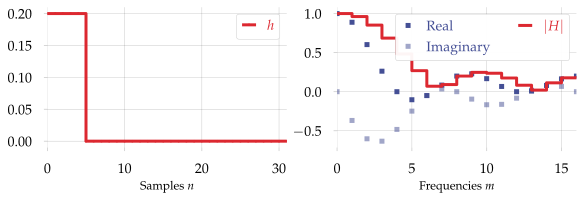

In [4]:
fig, (axt, axf) = plt.subplots(ncols=2, figsize=figaspect(1./3))

axt.step(np.arange(len(h)), h, marker='.', color=colors[1], where='post', label='$h$')
axt.set(xlabel='Samples $n$')
axt.legend(loc='upper right', labelcolor='linecolor')

axf.plot(H.real, marker='s', linestyle='', color=colors[11], label='Real')
axf.plot(H.imag, marker='s', linestyle='', color=colors[11], alpha=0.5, label='Imaginary')
axf.step(np.arange(len(H)), np.abs(H), color=colors[1], where='post', label='$|H|$')
axf.set(xlabel='Frequencies $m$')

axf.legend(loc='upper right', ncol=2, labelcolor='markerfacecolor')
#axf.axvspan(N/2, N, color=colors[3], alpha=0.1, zorder=-2)
glue('filter-mag', fig, display=False)

```{glue:figure} filter-mag
:name: filter-mag

**Left**: an order-5 moving average filter $\red{h}$.
**Right**: its DFT $\red{H}$ (real and imaginary components), as well as its magnitude spectrum $|\red{H}|$.
```

As {numref}`filter-mag` shows, some frequencies are attenuated substantially, but the effect is not monotonic: the magnitude curve $|\red{H}|$ has *ripples*, and some higher frequencies are less attenuated than lower frequencies.

This is why the moving average filter is not particularly good, and should not be used in practice!
Note, however, that we learned this entirely by analyzing the filter itself through the lens of the convolution theorem.

## The "ideal" low-pass filter

An alternative approach to building a filter would be to start in the frequency domain.
If we want to get rid of all frequencies above some cut-off $f_c$, why not just set $\red{H[m] = 0}$ (if $f_m > f_c$) and $\red{H[m] = 1}$ otherwise?
This way, low frequencies should be preserved exactly, and high frequencies will be completely eradicated, right?

This type of filter is known as an **ideal low-pass filter** (LPF) or a *brick-wall filter*.
For example, if we want to apply an ideal low-pass filter $f \geq 5$ with $f_s = N = 32$ as in our running example, we could do the following in Python:

```{code-block} python
fs = 32
N = 32

# Initialize the filter as ones
H = np.ones(1 + N // 2, dtype=np.complex)

# Get the analysis frequencies
freqs = np.fft.rfftfreq(N, d=1/fs)

# Set any frequencies above the cutoff to 0
cutoff = 5
H[freqs >= cutoff] = 0

# Invert to recover the time-domain filter
h = np.fft.irfft(H)
```
The result of this process is visualized below.

````{margin}

Note that in {numref}`brickwall`, the impulse response $h$ peaks at the beginning and end of the filter, and is relatively low in the middle.
It can be easier to visualize if we circularly shift the filter so that it peaks in the center.
This will change the delay characteristics of the filter, but not its frequency response.

This can be done manually by `np.fft.fftshift(h)`.
Note that most FIR filter constructors, like those covered in the next section, will implement this automatically for you.

```{glue:figure} brickwall-shifted
```
````

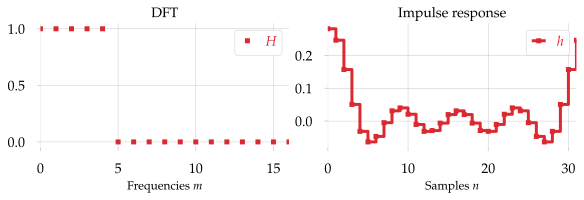

In [5]:
fig, (axf, axt) = plt.subplots(ncols=2, figsize=figaspect(1./3))

fs = 32
N = 32

# Initialize the filter as ones
H = np.ones(1 + N // 2, dtype=np.complex)

# Get the analysis frequencies
freqs = np.fft.rfftfreq(N, d=1/fs)

# Set any frequencies above the cutoff to 0
f_cutoff = 5
H[freqs >= f_cutoff] = 0

# Invert to recover the time-domain filter
h = np.fft.irfft(H)

axt.step(np.arange(len(h)), h, marker='s', color=colors[1], where='post', label='$h$')
axt.set(xlabel='Samples $n$')
axt.legend(loc='upper right', labelcolor='linecolor')

axf.plot(np.abs(H), color=colors[1], label='$H$', marker='s', linestyle='')
axf.set(xlabel='Frequencies $m$')

axf.legend(loc='upper right', ncol=2, labelcolor='markerfacecolor')
axf.set_title('DFT')
axt.set_title('Impulse response')
glue('brickwall-mag', fig, display=False)

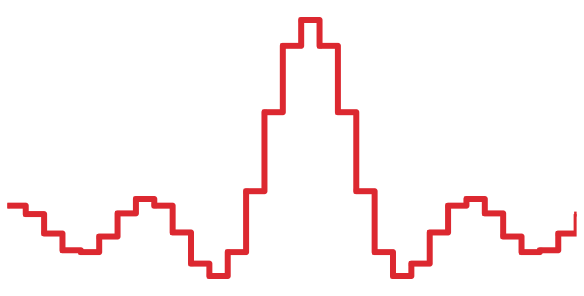

In [6]:
fig, ax = plt.subplots(figsize=figaspect(0.5))

ax.step(np.arange(len(h)), np.fft.fftshift(h), marker='s', color=colors[1], where='post', linewidth=6)
ax.set(yticks=[], xticks=[])
glue('brickwall-shifted', fig, display=False)

```{glue:figure} brickwall-mag
:name: brickwall

**Left**: an ideal low-pass filter $\red{H}$ is constructed for $f_s=32$, $N=32$, and $f_c = 5$.
**Right**: the time-domain filter is recovered by $\red{h} = \text{IDFT}(\red{H})$.
```

{numref}`brickwall` illustrates the time-domain representation (impulse response) $\red{h}$ of the "ideal" low-pass filter $\red{H}$ constructed in the frequency domain.
It may be surprising that $\red{h}$ appears to be periodic, and oscillates around 0.
However, this can be understood by reasoning about its inverse DFT as a sum of cosines (since the imaginary parts of $\red{H}$ are all 0):

```{margin}
The range of the summation here is -4 to +4.
Note that {numref}`brickwall` shows only the non-negative frequencies.
The terms $m=0,\dots,4$ come from the non-negative frequencies, and terms $m=-4,\dots,-1 \equiv N-4,\cdots,N-1$ come from DFT conjugate symmetry.
```

```{math}
\red{h[n]} = \frac{1}{N} \cdot \sum_{m=-4}^{4} \cos\left(2\pi \cdot \frac{m}{N} \cdot n\right)
```

These oscillations produce audible artifacts, known as **ringing**, when $\red{h}$ is convolved with a signal.
The example below demonstrates this, using an audio clip of a slide whistle and an ideal low-pass filter at 500 Hz: ringing at the cut-off frequency is audible in the low-pass filtered output.
For comparison purposes, a moving average filter is also included.

In [7]:
import soundfile as sf
from IPython.display import Audio, display

# https://freesound.org/s/517633/
x, fs = sf.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

N = len(x)

# Define the cutoff frequency
f_cutoff = 500

#---
# For comparison, a moving average filter
# at fs [samples / second] and f_cutoff [cycles / second]
# we get an order K = fs / f_cutoff [samples / cycle]
K = fs // f_cutoff
h_ma = np.ones(K) / K

# Filter the signal: moving average
y_ma = scipy.signal.convolve(x, h_ma)


#---
# ideal LPF
X = np.fft.rfft(x)

# Set all DFT components to 0 if the frequency exceeds cutoff
freqs = np.fft.rfftfreq(N, 1/fs)
X[freqs >= f_cutoff] = 0

# Invert the DFT to get the output
y = np.fft.irfft(X)

#---
# Play the results
display('Original signal')
display(Audio(data=x, rate=fs))

display(f'Moving average, cutoff = {f_cutoff} Hz')
display(Audio(data=y_ma, rate=fs))

display(f'Ideal LPF, cutoff = {f_cutoff} Hz')
display(Audio(data=y, rate=fs))

'Original signal'

'Moving average, cutoff = 500 Hz'

'Ideal LPF, cutoff = 500 Hz'

In principle, the ideal LPF ought to work, but its utility is limited in practice by the length of the filter, which determines the number of analysis frequencies.
Just as sharp edges (e.g., impulses) in the time domain are difficult to represent by continuous sinusoids, the same is true for sharp edges in the *frequency domain*.
The sharper the filter is in the frequency domain, the more frequencies (equivalently, time-domain samples) are necessary to represent it accurately.
The ideal filter is infinitely sharp --- it has a slope of $-\infty$ at the cutoff frequency --- so it requires infinitely many samples to represent in the time domain.
Any finite approximation we take, like the one above, will produce ringing artifacts.

Because of these ringing artifacts, ideal low-pass filters are almost never used in practice.
However, they can be modified to produce better filters, as we will see in the next section.